In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as itertools
from scipy.fft import fft, fftfreq
from copy import deepcopy 

In [2]:
%connect_info

{"key":"953497f9-ded0-4c06-85be-7e8b49ee16a2","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9000,"control_port":9001,"shell_port":9002,"stdin_port":9003,"iopub_port":9004,"kernel_name":"python3112jvsc74a57bd04149aa2f31a7f8b5ff184e82bf464dce73529b69401cc2940ad6232b832b4da8"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v3be3d4370fae05d3321565df5e9a3b5895f72bb8b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [3]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp
from hypyp.signal import SynteticSignal
from hypyp.plots import (
    spectrogram_plot,
    spectrogram_plot_period,
    plot_coifs,
    plot_coefs,
    plot_im_diff,
    plot_line,
    plot_S12,
    plot_times,
    plot_spectrogram_periods
)
from hypyp.fnirs_tools import (
    xwt_coherence_morl,
    smoothing
)
from hypyp.fnirs_tools_orig import (
    xwt_coherence_morl_orig
)

import pywt
import pycwt


Loading pywt from /home/patrice/work/ppsp/pywt/pywt
Loading pycwt from /home/patrice/work/ppsp/pycwt/pycwt


ninja: error: '/tmp/pip-build-env-tiw5qk87/overlay/bin/cython', needed by 'pywt/_extensions/_cwt.cpython-311-x86_64-linux-gnu.so.p/_cwt.c', missing and no known rule to make it


## Load snirfs

In [4]:
fname1 = '../data/sub-110_session-1_pre_raw.fif'
fname2 = '../data/sub-110_session-1_pre_raw.fif'

chs1 = ["S4_D4 hbo"] 
chs2 = ["S7_D6 hbo"]

#set events
tmin = 0 
tmax = 300
baseline = (0, 0)

from hypyp.fnirs import Subject, DyadFNIRS

dyad = DyadFNIRS(
    Subject().load_snirf_file(fname1).set_best_ch_names(chs1),
    Subject().load_snirf_file(fname2).set_best_ch_names(chs2)
).load_epochs(tmin, tmax, baseline)




Opening raw data file ../data/sub-110_session-1_pre_raw.fif...


    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Opening raw data file ../data/sub-110_session-1_pre_raw.fif...
    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


## Sine waves

## CWT
Continuous Wavelet Transform

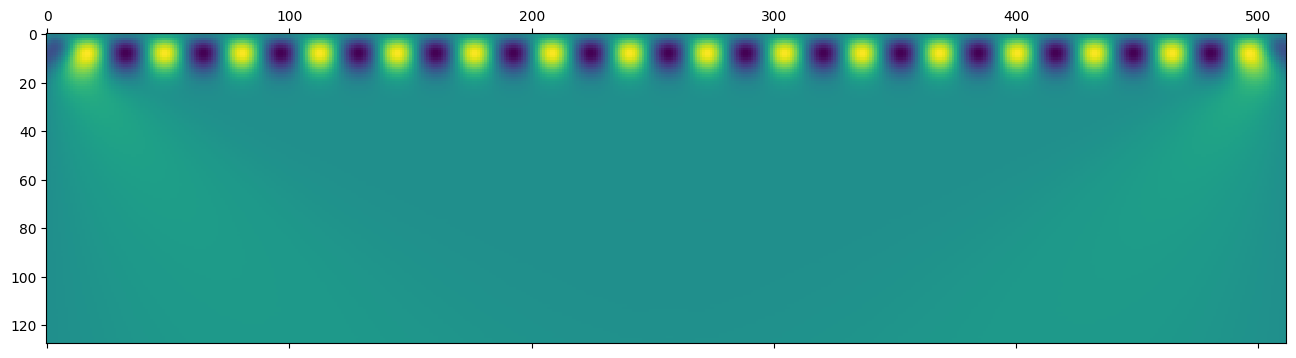

In [5]:
x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef)
plt.show()

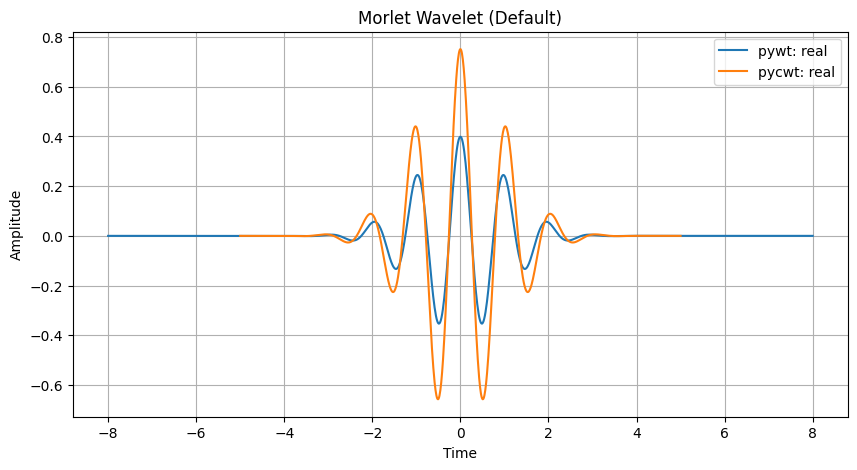

In [6]:
# pycwt.cwt
# Define the range of time values

[psi_pywt, x_pwtw] = pywt.ContinuousWavelet('cmor2, 1').wavefun(10)

morlet_wavelet_pycwt = pycwt.wavelet.Morlet()

# Calculate the wavelet values
t_pycwt = np.linspace(-5, 5, 1000)
wavelet_values_pycwt = morlet_wavelet_pycwt.psi(t_pycwt)

# Plot the wavelet
plt.figure(figsize=(10, 5))
plt.plot(x_pwtw, np.real(psi_pywt), label="pywt: real")
#plt.plot(x, np.imag(psi_pywt), label="pywt: imag")
plt.plot(t_pycwt, wavelet_values_pycwt.real, label='pycwt: real')
#plt.plot(t, wavelet_values.imag, label='pycwt: imag')
plt.title('Morlet Wavelet (Default)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()



In [7]:

# take N from real data
N = len(dyad.s1.epochs.get_data()[0,0,:]) # N = 1501
sfreq = dyad.s1.epochs.info['sfreq'] # 5.0


Using data from preloaded Raw for 4 events and 1501 original time points ...
1 bad epochs dropped


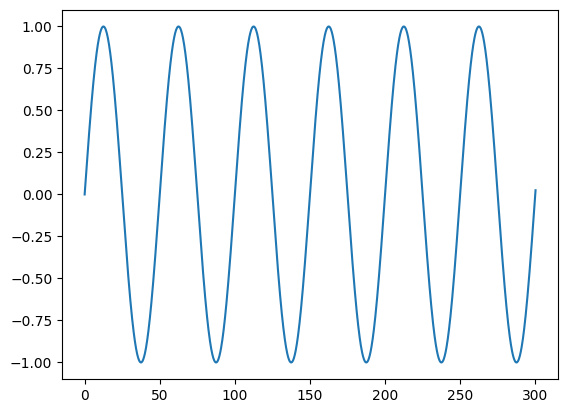

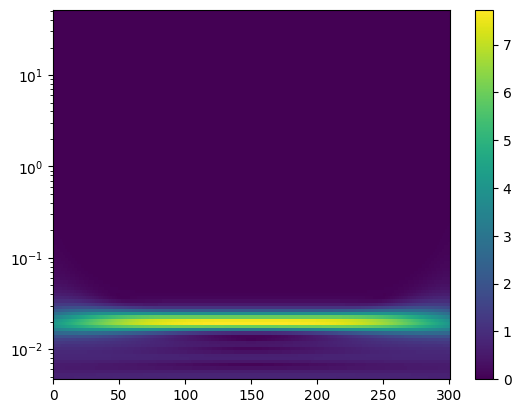

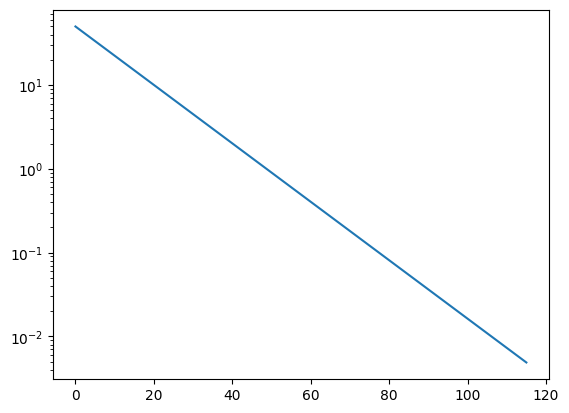

In [8]:
# pywt.cwt

scales = np.geomspace(0.1, 1024, num=116)
#sig = SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(0.02).add_sin(0.04).add_noise()
sig = SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(0.02)
W_pywt, freqs_pywt = pywt.cwt(
    sig.y,
    scales,
    #'gaus1'
    'cmor2, 1',
    sampling_period=1/sig.sample_rate
)

plt.plot(sig.times_vec, sig.y)
plt.show()
#plt.matshow(np.real(W))
#plt.show()
#plt.matshow(np.imag(W))
#plt.show()
plt.figure()
plt.pcolormesh(sig.times_vec, freqs_pywt, np.abs(W_pywt), cmap='viridis')
plt.colorbar()
plt.yscale('log')
plt.show()

plt.plot(freqs_pywt)
plt.yscale('log')



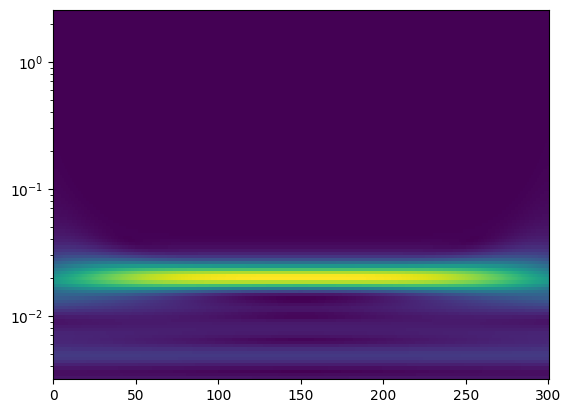

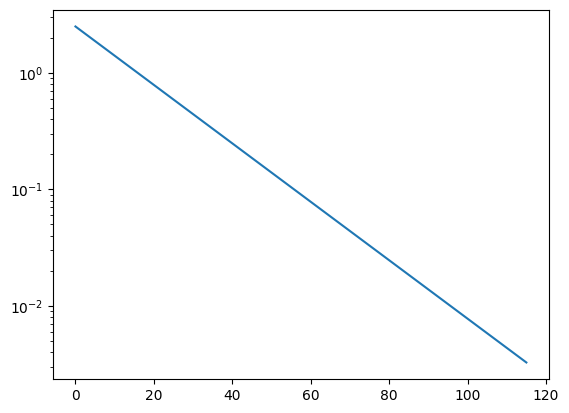

In [9]:

dt = 1/sig.sample_rate
dj = 1/12
# Smallest resolvable scale
s0 = 2 * dt / pycwt.Morlet().flambda()
# Number of scales
J = int(np.round(np.log2(N * dt / s0) / dj))
# The scales as of Mallat 1999
scales = s0 * 2 ** (np.arange(0, J + 1) * dj)

sig = SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(0.02)
W_pycwt, sj, freqs_pycwt, coi_pycwt, fft, fftfreqs = pycwt.cwt(
    sig.y,
    dt,
    scales
)

#plt.matshow(np.real(W_pycwt))
#plt.show()
#plt.matshow(np.imag(W_pycwt))
#plt.show()
plt.pcolormesh(sig.x, freqs_pycwt, np.abs(W_pycwt))
plt.yscale('log')
plt.show()

plt.plot(freqs_pycwt)
plt.yscale('log')


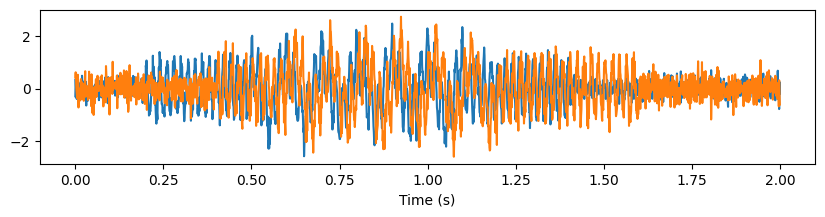

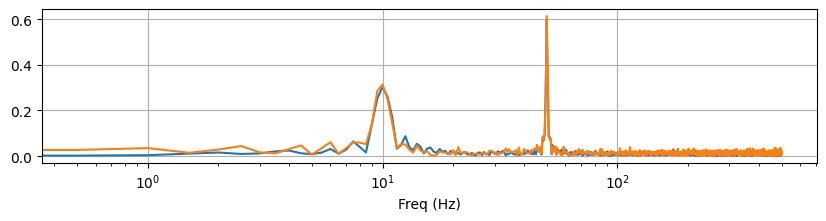

In [10]:

# take N from real data
#N = len(dyad.s1.epochs.get_data()[0,0,:]) # N = 1501
N = 3000
sfreq = dyad.s1.epochs.info['sfreq'] # 5.0
#sfreq = 20
period = 1 / sfreq
#signal_freqs = [1/25, 1/30]
#signal_freqs = [1/50, 1/25]

#signals = [SynteticSignal(tmax=N/sfreq, n_points=N).add_sin(signal_freq) for signal_freq in signal_freqs]
#signals = [SynteticSignal(tmax=N/sfreq, n_points=N).add_chirp(f0, f1).add_noise(level=0.05) for f0, f1 in [(0.02, 0.04), (0.04, 0.02)]]
#signals = [SynteticSignal(tmax=N/sfreq, n_points=N).add_noise() for f0, f1 in [(0.02, 0.04), (0.04, 0.02)]]

# signals from https://www.mathworks.com/help/wavelet/ref/wcoherence.html
t = np.linspace(0, 2, 2000)
y1 = np.cos(2*np.pi*10*t) * (t>=0.5).astype(int) * (t<1.1).astype(int) + np.cos(2*np.pi*50*t) * (t>= 0.2).astype(int) * (t<1.4).astype(int) + 0.25*np.random.normal(0, 1, len(t))
y2 = np.sin(2*np.pi*10*t) * (t>=0.6).astype(int) * (t<1.2).astype(int) + np.sin(2*np.pi*50*t) * (t>= 0.4).astype(int) * (t<1.6).astype(int) + 0.35*np.random.normal(0, 1, len(t))
signals = [
    SynteticSignal(tmax=2, n_points=2000).add_custom(y1),
    SynteticSignal(tmax=2, n_points=2000).add_custom(y2)
]

plt.figure(figsize=(10, 2))
[sig.plot() for sig in signals]
plt.show()

plt.figure(figsize=(10,2))
[sig.plot_fft() for sig in signals]
plt.grid()
plt.show()


## WCT

Doing pycwt
Doing pywt
Done
shape of wct: (200, 2000)
0.5729628856080345
shape of wct: (121, 2000)
0.45855262194851226
signal: (2000,)
signal: (2000,)


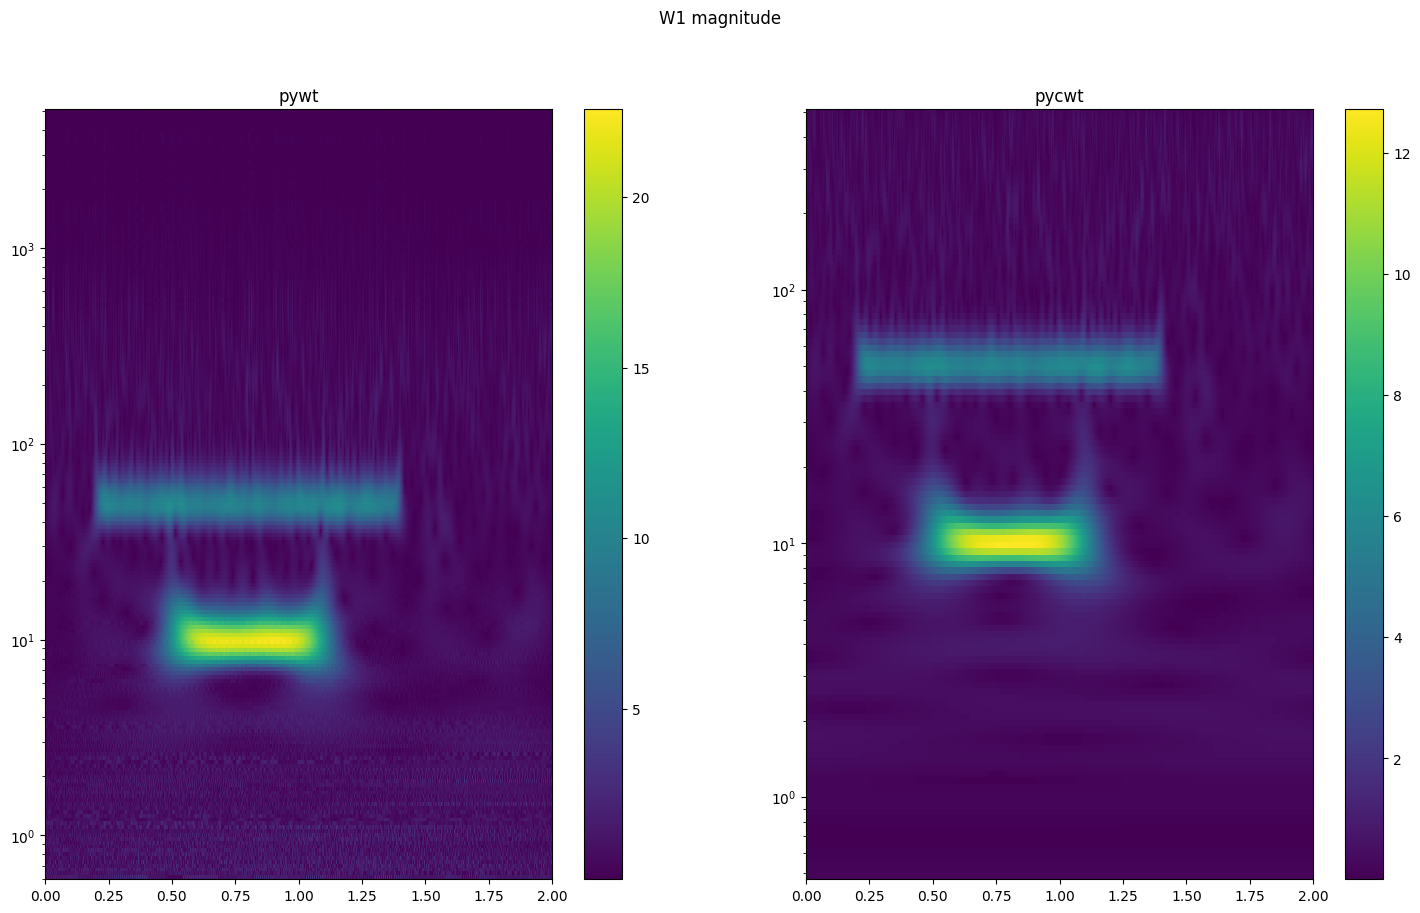

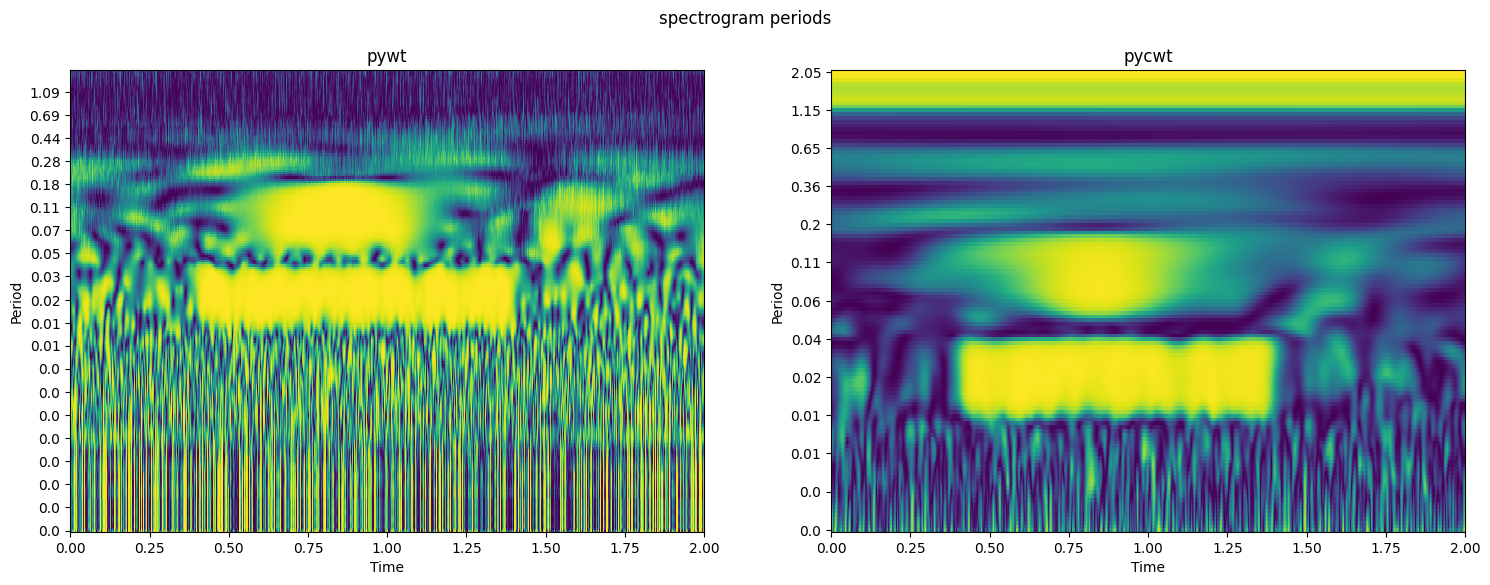

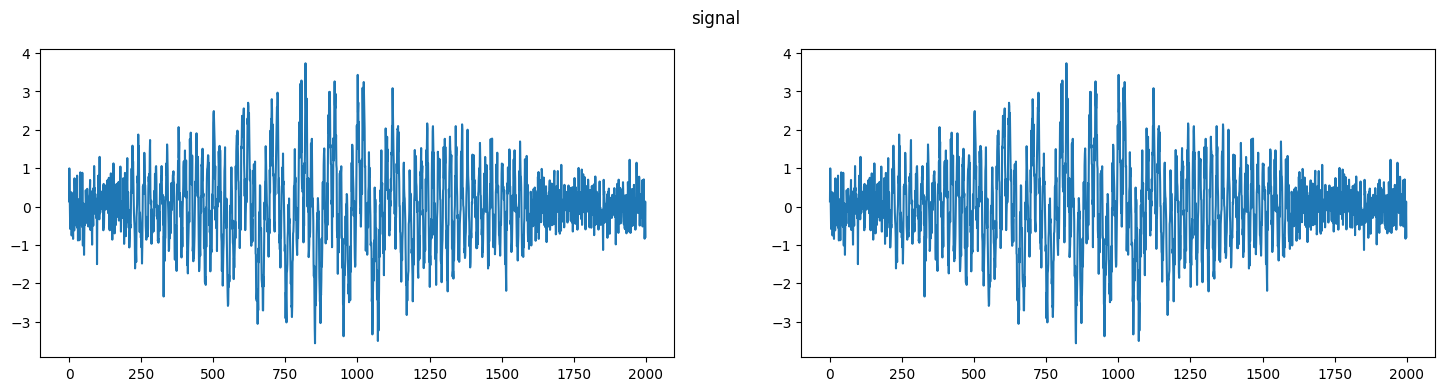

scales (sj): (200,)
scales (sj): (121,)


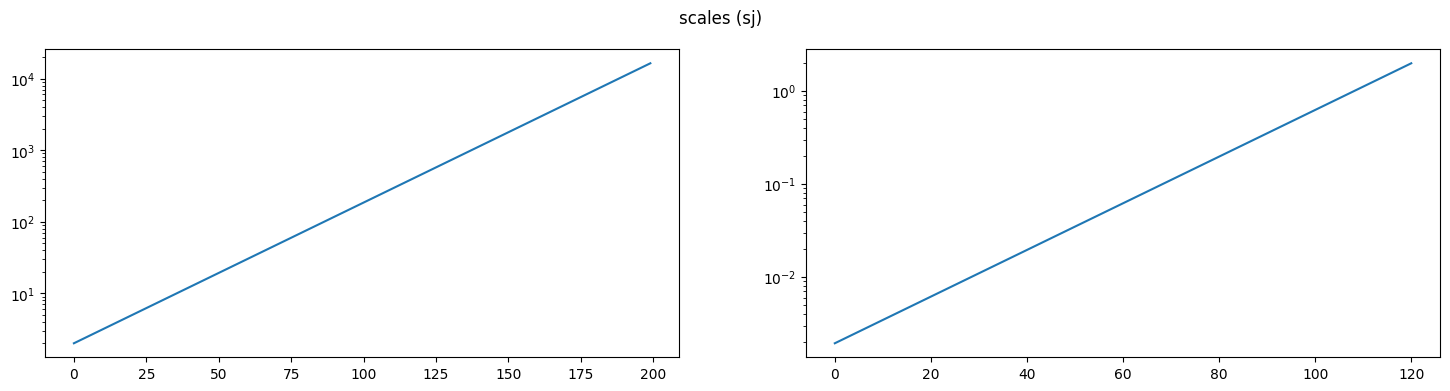

frequencies: (200,)
frequencies: (121,)


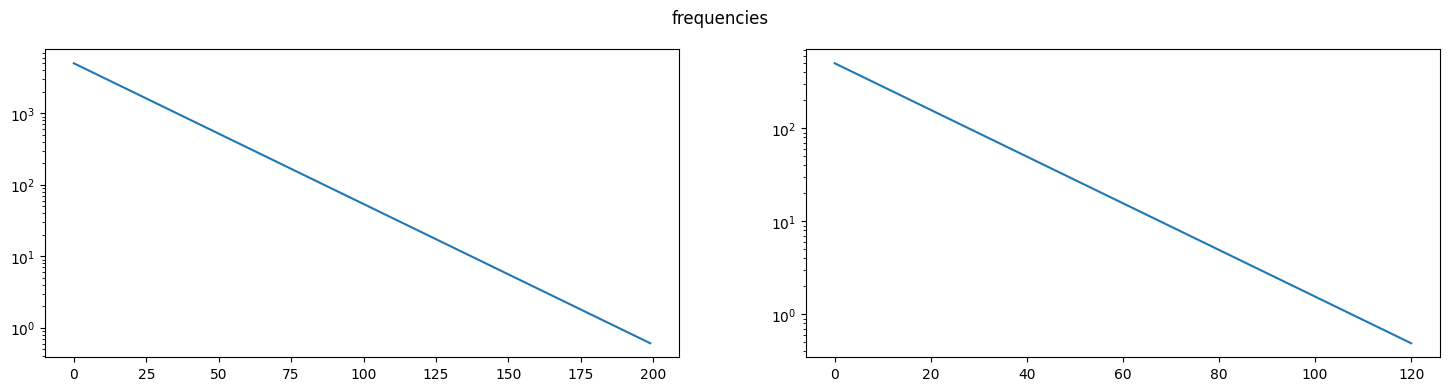

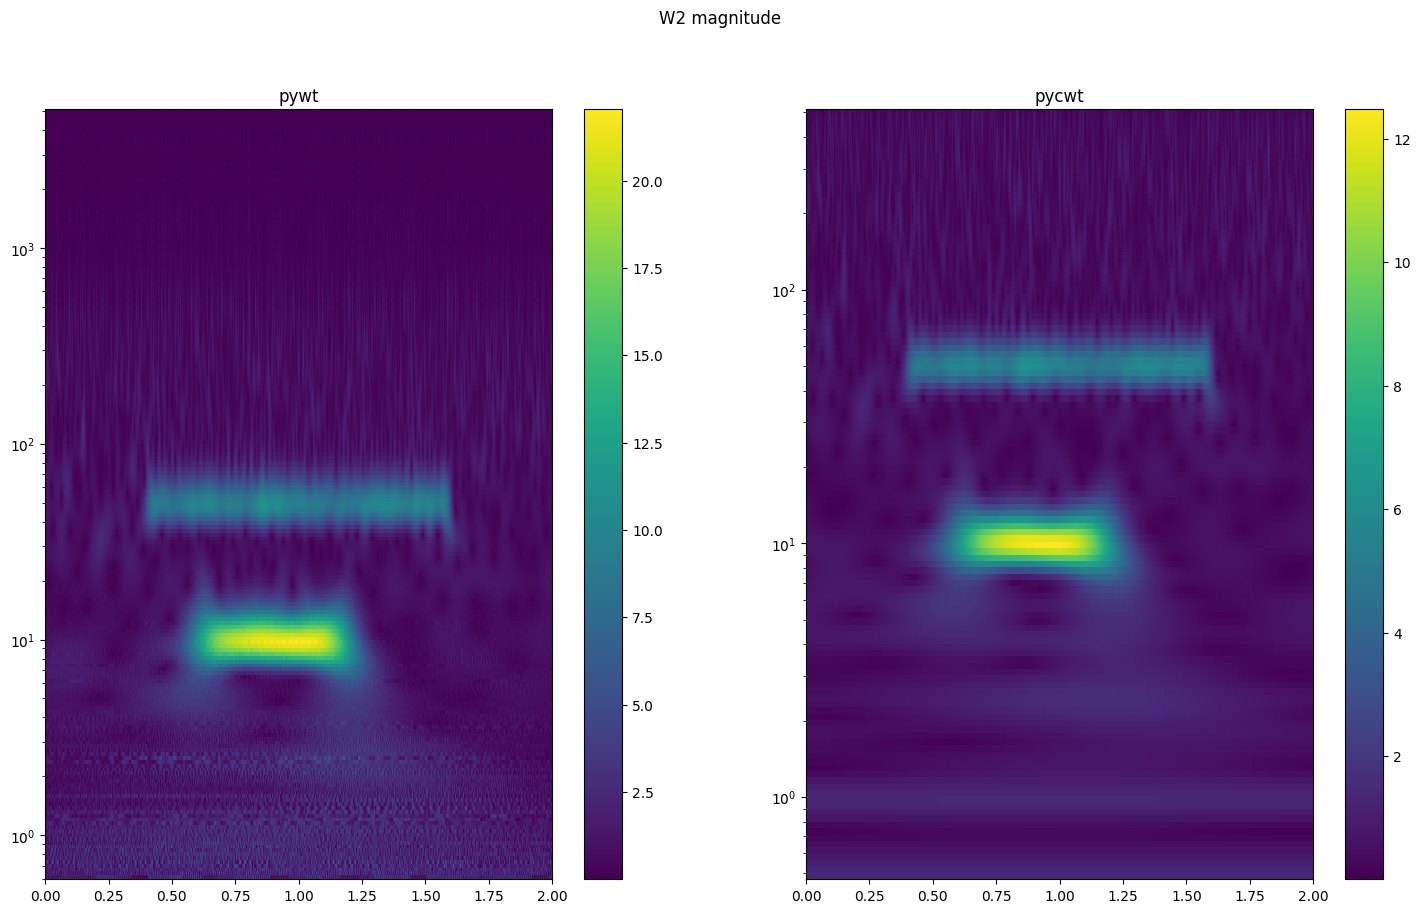

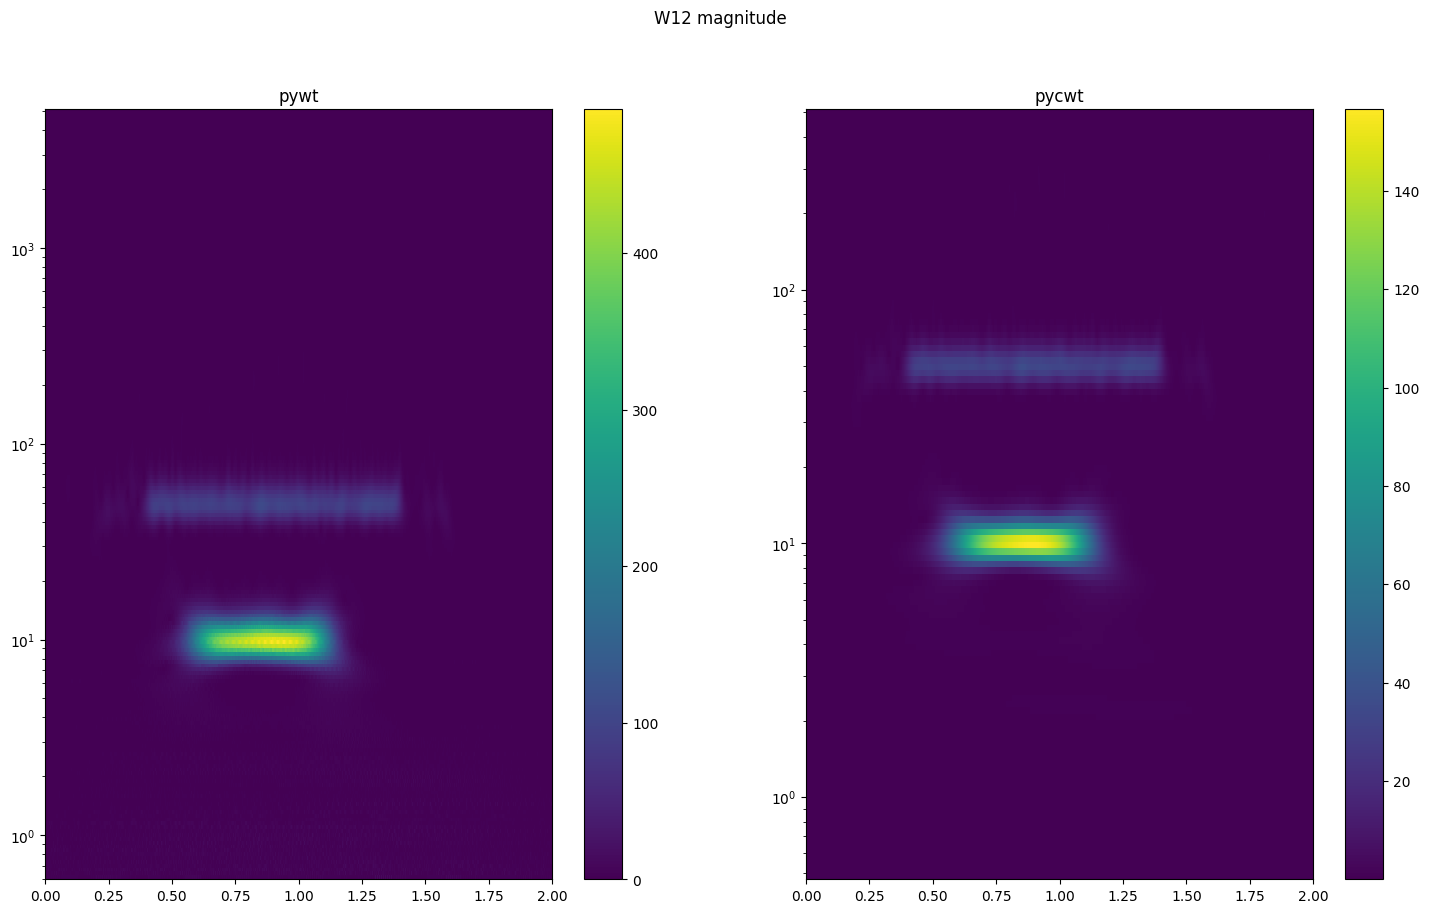

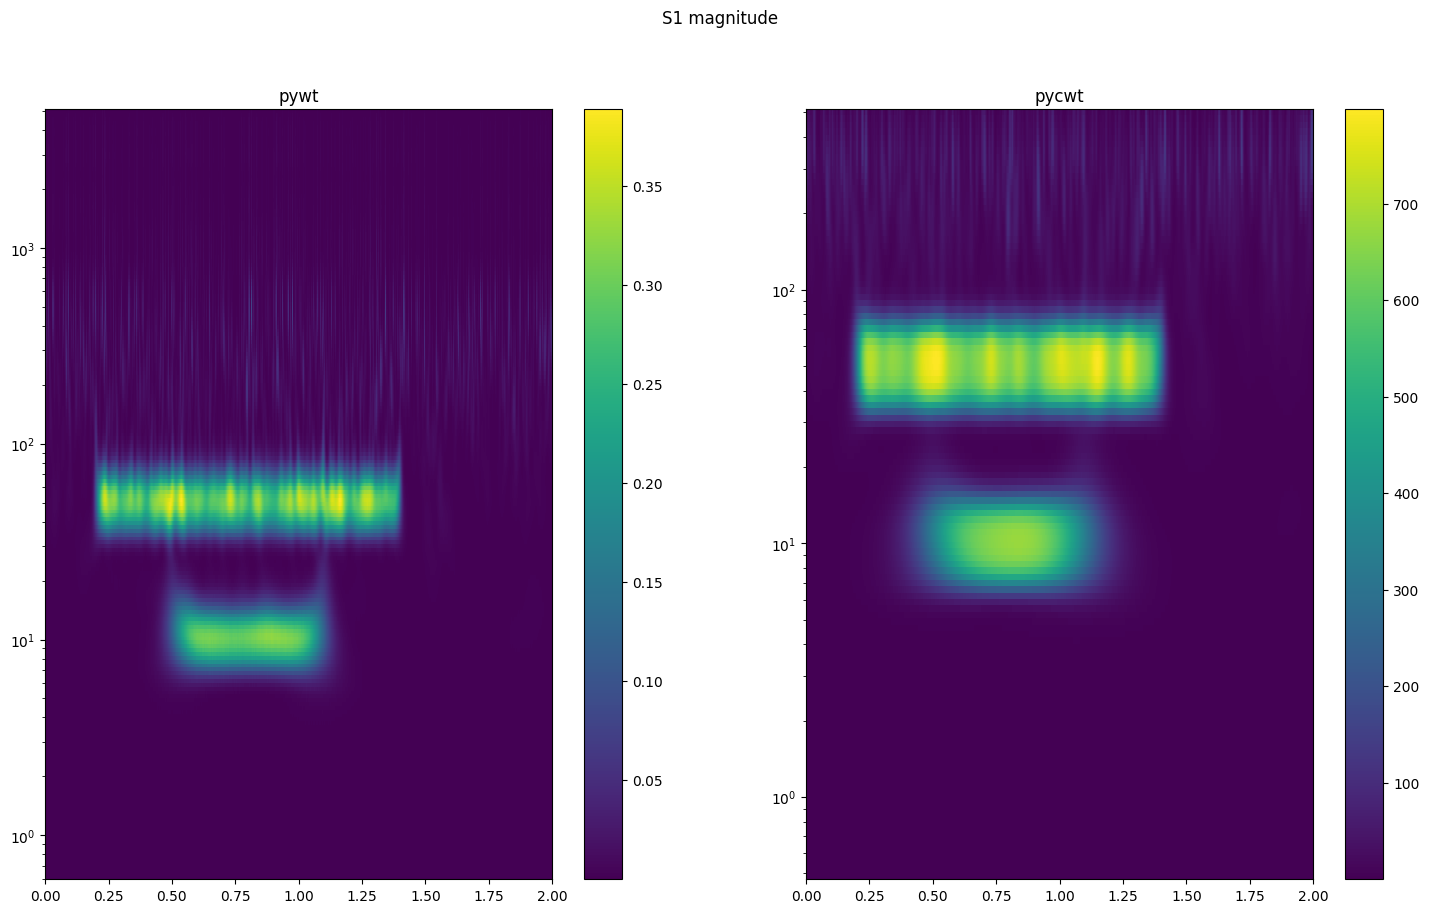

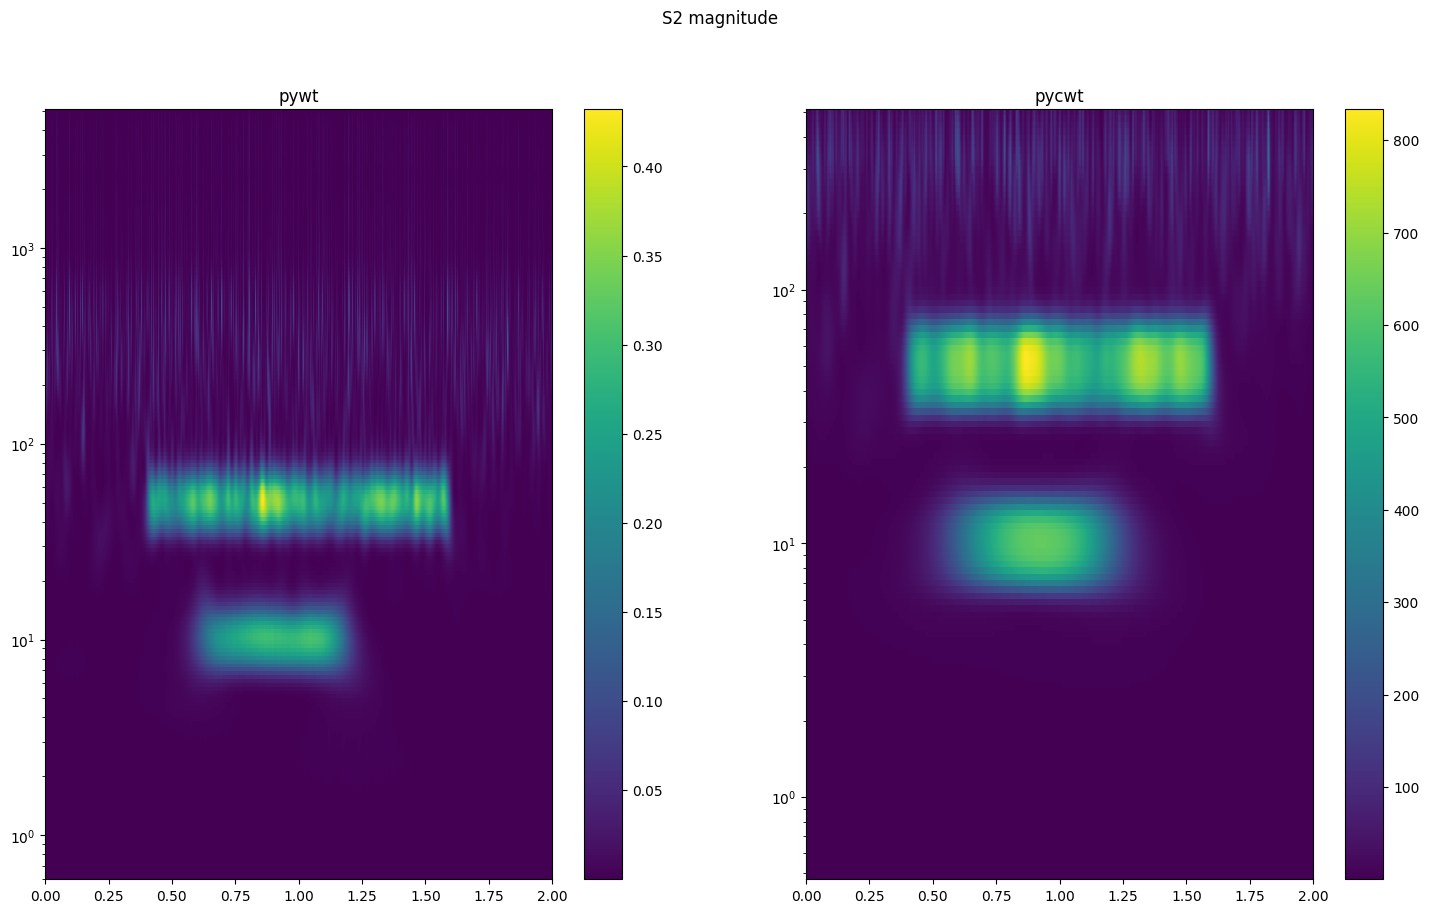

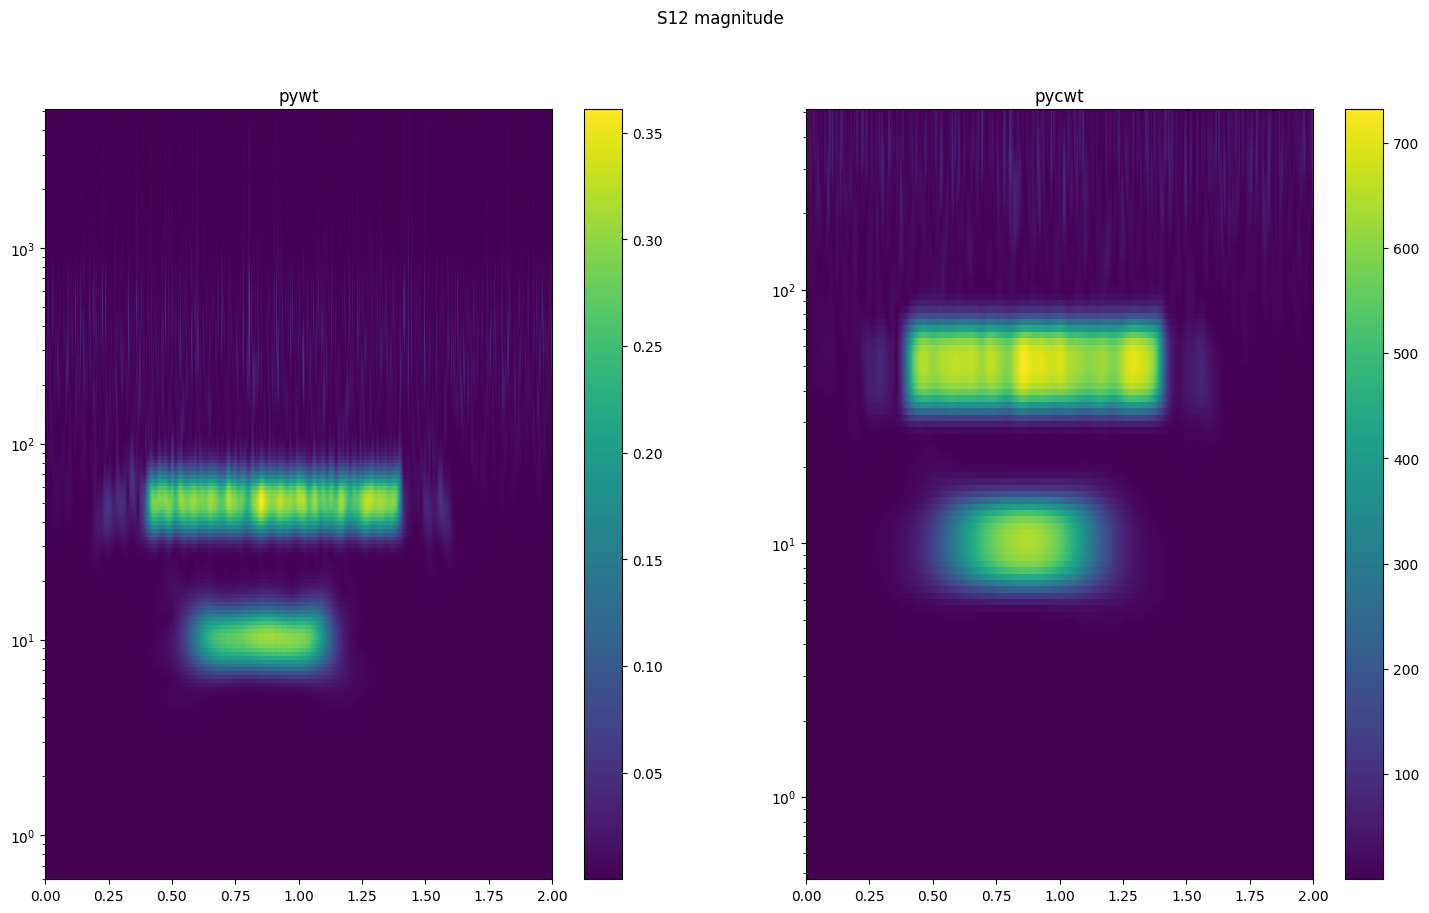

In [ ]:
import matplotlib.cm as cm

items = [dict() for _ in range(2)]
tracers = [
    dict(name='pywt'),
    dict(name='pycwt'),
]

print("Doing pycwt")

wtc_pycwt, aWTC_pycwt, coif_pycwt, freqs_pycwt, sig_pycwt = pycwt.wct(
    signals[0].y,
    signals[1].y,
    dt=1/signals[0].sample_rate,
    sig=False,
    tracer=tracers[1] # index 1 to have it on the right side
)
items[1] = dict(
    wtc=wtc_pycwt,
    times=signals[0].times_vec, # this does not come from pycwt.wct
    freq=freqs_pycwt,
    coif=coif_pycwt,
    dt=1/signals[0].sample_rate,
    dj=1/12,
)

# Mega HACK, use the tracer to get the W1 and W2 from pycwt
tracer_hack = tracers[1]

print("Doing pywt")
wtc, times, freq, coif = xwt_coherence_morl(
    signals[0].y,
    signals[1].y,
    dt=1/signals[0].sample_rate,
    tracer=tracers[0],
    smoothing_params=dict(smooth_factor=0, boxcar_size=0.6),
    #wavelet_pywct=pycwt.Morlet(),
    #W1_pywct=tracer_hack['W1'],
    #W2_pywct=tracer_hack['W2'],
    #freq_pywct=tracer_hack['freq'],
)
items[0] = dict(
    wtc=wtc,
    times=signals[0].times_vec,
    freq=freq,
    coif=coif,
    dt=1/signals[0].sample_rate,
    dj=1/12,
)

print("Done")

plot_coefs(tracers, 'W1', 'W1 magnitude')
plot_spectrogram_periods(items, tracers)
plot_line([dict(y=signals[0].y+signals[1].y) for _ in range(2)], 'y', 'signal')

plot_line(tracers, 'scales', 'scales (sj)', use_log_scale=True)
plot_line(tracers, 'freq', 'frequencies', use_log_scale=True)
#plot_im(tracers, 'S1')
#plot_im(tracers, 'S2')
#plot_S12(tracers)
plot_coefs(tracers, 'W2', 'W2 magnitude')
plot_coefs(tracers, 'W12', 'W12 magnitude')
plot_coefs(tracers, 'S1', 'S1 magnitude')
plot_coefs(tracers, 'S2', 'S2 magnitude')
plot_coefs(tracers, 'S12', 'S12 magnitude')
#plot_im_diff(tracers[0]['S1'], tracers[1]['S1'], 'S1: ours wct minus pycwt.wct')
#plot_im_diff(tracers[1]['S2'], tracers[2]['S2'], 'S2: ours wct minus pycwt.wct')
#plot_coifs(items)
#plot_times(items)

(200, 2000)


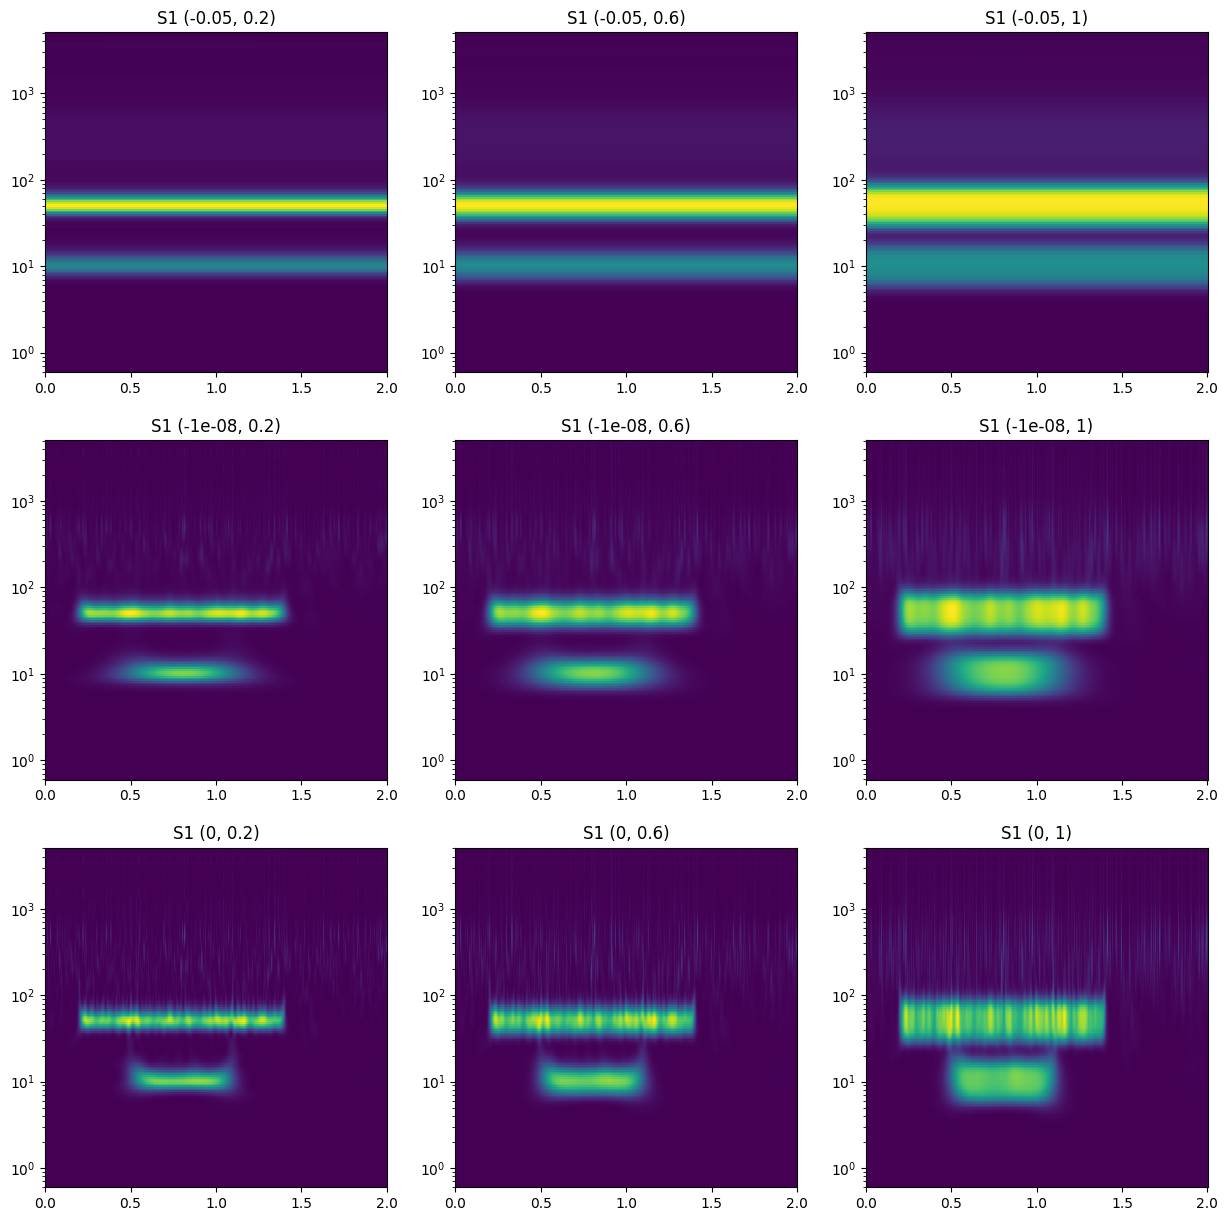

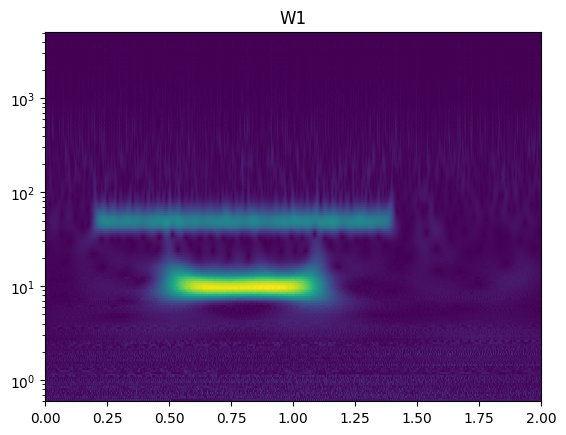

In [ ]:
scaleMatrix = np.ones([1, np.abs(tracers[0]['W1'].shape[1])]) * tracers[0]['scales'][:, None]
print(scaleMatrix.shape)

smooth_factors = [-0.05, -0.00000001, 0]
boxcar_sizes = [0.2, 0.6, 1]
fig, axes = plt.subplots(len(smooth_factors), len(boxcar_sizes), figsize=(15, 15))

for i, smooth_factor in enumerate(smooth_factors):
    for j, boxcar_size in enumerate(boxcar_sizes):
        ax = axes[i,j]
        dt = 1/signals[0].sample_rate
        dj = 1/12
        S1 = smoothing(np.abs(deepcopy(tracers[0]['W1'])) ** 2 / scaleMatrix, dt, dj, tracers[0]['scales'], smooth_factor=smooth_factor, boxcar_size=boxcar_size)
        ax.pcolormesh(tracers[0]['x1'], tracers[0]['freq'], S1)
        ax.set_yscale('log')
        ax.title.set_text(f'S1 ({smooth_factor}, {boxcar_size})')
plt.show()

plt.pcolormesh(tracers[0]['x1'], tracers[0]['freq'], np.abs(tracers[0]['W1']))
plt.yscale('log')
plt.title('W1')
plt.show()


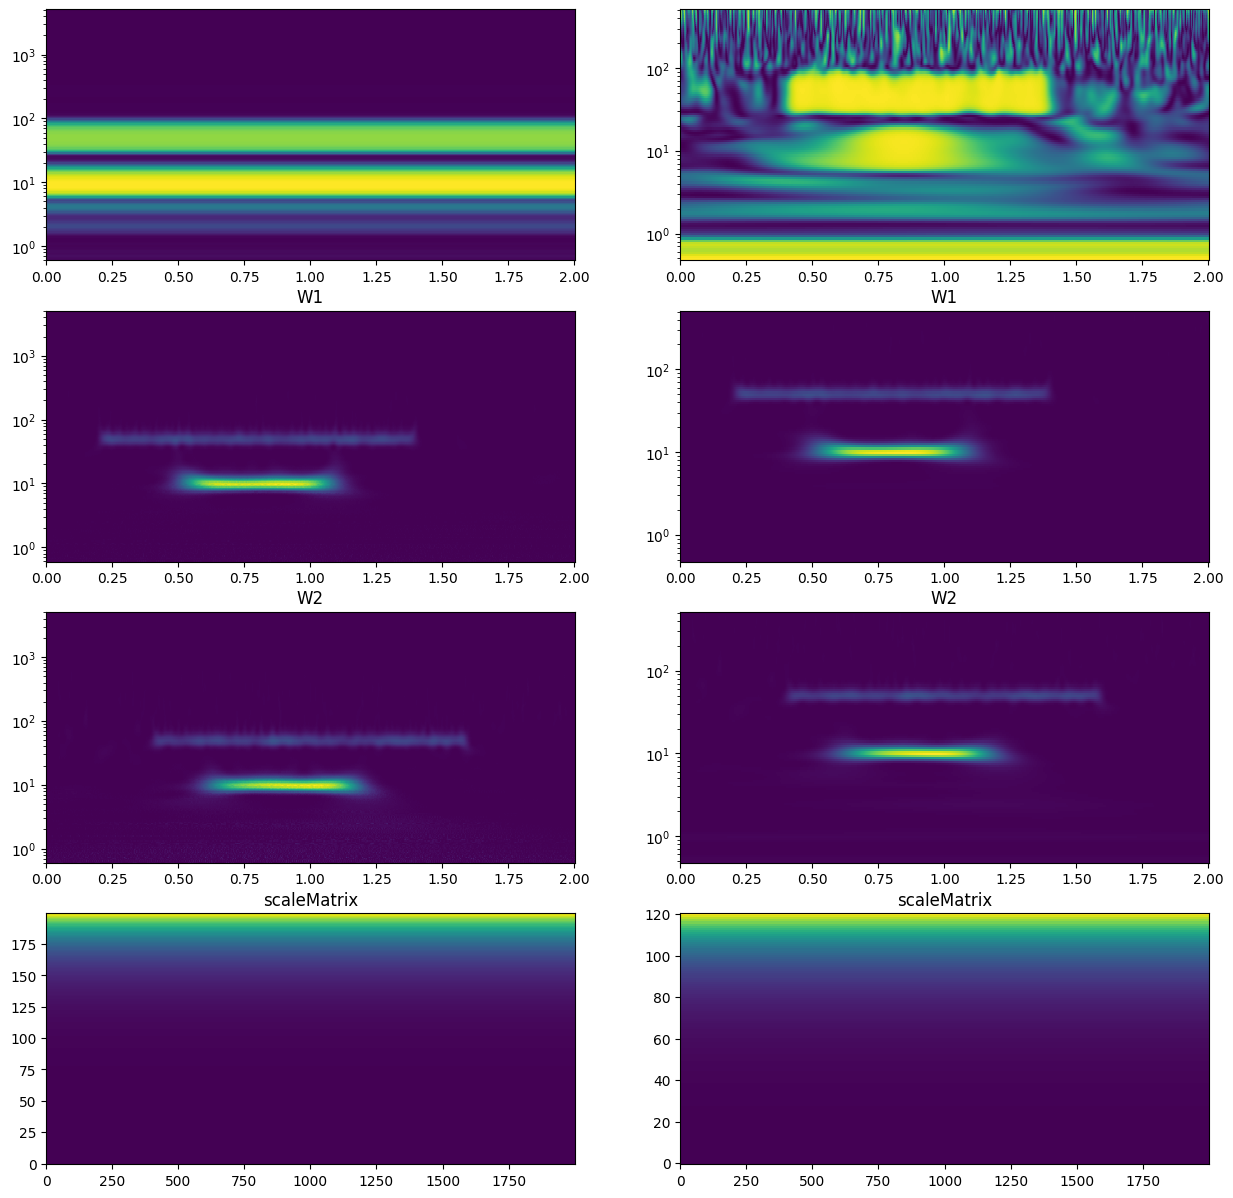

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

for i, item in enumerate(items):
    tracer = tracers[i]
    #wct = item['wct']
    #wct = np.abs(tracer['S12']) ** 2 / (tracer['S1'] * tracer['S2'])
    scaleMatrix = np.ones([1, len(tracer['x1'])]) * tracer['scales'][:, None]
    W1_power = np.abs(tracer['W1']) ** 2
    W2_power = np.abs(tracer['W2']) ** 2
    W12 = tracer['W12']
    dt = 1/signals[0].sample_rate
    dj = 1 / 12
    S1 = smoothing(W1_power / scaleMatrix, item['dt'], item['dj'], tracer['scales'])
    S2 = smoothing(W2_power / scaleMatrix, item['dt'], item['dj'], tracer['scales'])
    S12 = smoothing(W12 / scaleMatrix, item['dt'], item['dj'], tracer['scales'])
    wtc = np.abs(S12) ** 2 / (S1 * S2)
    ax = axes[0, i]
    ax.pcolormesh(item['times'], item['freq'], wtc)
    ax.set_yscale('log')

    ax = axes[1, i]
    ax.pcolormesh(item['times'], item['freq'], W1_power)
    ax.set_yscale('log')
    ax.title.set_text('W1')

    ax = axes[2, i]
    ax.pcolormesh(item['times'], item['freq'], W2_power)
    ax.set_yscale('log')
    ax.title.set_text('W2')

    ax = axes[3, i]
    im = ax.pcolormesh(np.arange(0, len(item['times'])),np.arange(0, len(item['freq'])), scaleMatrix)
    # fig.colorbar(im, cax=ax, orientation='vertical')
    #ax.set_yscale('log')
    ax.title.set_text('scaleMatrix')
plt.show() 
